# Verification
In this notebook, we run the neural networks on samples coming from different simulation, i.e. simulations in which the spatial resolution is lower. We will use 1/4th and 2/3rds of a degree.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from pickle import dump, load

from scipy import ndimage as nd

import torch
from torchsummary import summary

import os

from ml_eke import *

In [2]:
columns = ['MKE_sfc',
           'Rd_dx_z',
           'relative_vorticity_sfc',
           'grad_SSH_sfc']

Here we can decide if we want to load the 1/4 or the 2/3 degree model.

In [12]:
model_path = './ml_eke/nn/pytorch/trained_models/ResNetExtraSmall_4_custom.pkl'
model_name = os.path.basename(model_path).split('.')[0]

model_mse = torch.load(model_path, map_location=torch.device('cuda'))
summary(model_mse, (4,))

scaler = np.load('ml_eke/nn/data/scaler_cf_all_4_noslope.npy')

datapaths_2_3 = ('/lus/scratch/arigazzi/ncar/data/2_3_SSH/', '/lus/scratch/arigazzi/ncar/data/2_3_SSH/')
first_suffixes_2_3 = ('_16_001.nc', '_16_001.nc')

datapaths_1_4 = ('/lus/scratch/arigazzi/ncar/data/1_4_SSH/', '/lus/scratch/ashao/data/1_4_SSH/')
first_suffixes_1_4 = ('_1916_001.nc', '_18_001.nc')

columns[1] = 'Rd_dx_sfc'

datapaths = datapaths_1_4
first_suffixes = first_suffixes_1_4

model_data = pop_data(datapaths[0], datapaths[0], skip_vars = ['x','y','depth','depth_stdev'], extra_pref=None, first_suffix=first_suffixes[0])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1              [-1, 4, 2, 2]              68
       BatchNorm2d-2              [-1, 4, 2, 2]               8
              ReLU-3              [-1, 4, 2, 2]               0
        TransBlock-4              [-1, 4, 2, 2]               0
   ConvTranspose2d-5              [-1, 4, 3, 3]              68
       BatchNorm2d-6              [-1, 4, 3, 3]               8
              ReLU-7              [-1, 4, 3, 3]               0
        TransBlock-8              [-1, 4, 3, 3]               0
   ConvTranspose2d-9              [-1, 4, 4, 4]              68
      BatchNorm2d-10              [-1, 4, 4, 4]               8
             ReLU-11              [-1, 4, 4, 4]               0
       TransBlock-12              [-1, 4, 4, 4]               0
           Conv2d-13              [-1, 4, 4, 4]              16
      BatchNorm2d-14              [-1, 

In [8]:
# Depending on what the device is
predict_cpu = lambda model, X: model(torch.tensor(X.values)).detach().numpy()
predict_gpu = lambda model, X: model(torch.tensor(X.values).cuda()).cpu().detach().numpy()

predict = predict_gpu

In [9]:
sample_id = 35

sample, target, mask = get_samples_2D(sample_id, sample_id+1, columns, model_data, predictands=['MEKE_z'])

disp_sample, disp_target, disp_pred_mse = prep_maps(sample, target, mask, scaler=scaler,
                                                    model=model_mse, columns=columns, predict_fn=predict,
                                                    abs_val=[False, True, True, False], 
                                                    clean_after_reg=True, skip_vars=[columns[1]])
mask_s = mask.squeeze()

Extracting 2D samples: 0it [00:00, ?it/s]


Dropping empty values...
Dropping negative EKE samples...
Removing EKE from features...
log(MKE_sfc)
id(Rd_dx_sfc)
log(abs(relative_vorticity_sfc))*sign
log(grad_SSH_sfc)
Scaling data with provided scaler...


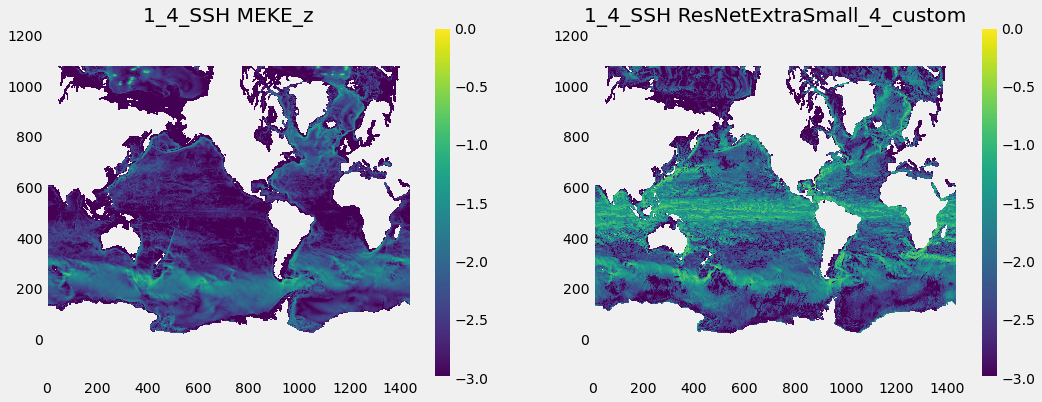

In [11]:
last_dir = os.path.normpath(datapaths[0]).split(os.sep)[-1]
scales='fixed'
savefig = False

if scales == 'adaptive':
    vmin = min(np.min(disp_target[mask_s]),
    np.min(disp_pred_mse[mask_s]))
    vmax = max(np.max(disp_target[mask_s]),
    np.max(disp_pred_mse[mask_s]))
elif scales == 'fixed':
    vmin = -3
    vmax = -0
else:
    scales='free'

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
if scales != 'free':
    plt.pcolormesh(np.log10(np.exp(disp_target)), vmin=vmin, vmax=vmax)
else:
    plt.pcolormesh(np.log10(np.exp(disp_target)))
plt.axis('equal')
plt.colorbar()
plt.title(f'{last_dir} MEKE_z')
plt.subplot(1,2,2)
if scales != 'free':
    plt.pcolormesh(np.log10(np.exp(disp_pred_mse)), vmin=vmin, vmax=vmax)
else:
    plt.pcolormesh(np.log10(np.exp(disp_pred_mse)))
plt.title(f'{last_dir} {model_name}')
plt.colorbar()
plt.axis('equal')
plt.draw()

if savefig:
    plt.savefig(f'{model_name}_{last_dir}_{scales}.png')